# **House Prices - Advanced Regression Techniques** 

(https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/) - *projekt na Uczenie Maszynowe*

*by Bartosz Rogowski & Aleksandra Rolka*


In [1]:
# running from Google collab
# -----------------------------------------------------------------
# from google.colab import drive
# drive.mount('/content/drive')

# !unzip drive/Shareddrives/ML-team/house-prices-advanced-regression-techniques.zip -d data
# data_folder_path = '/content/data'


# running locally
# -----------------------------------------------------------------
data_folder_path = './data/'

In [ ]:
!pip install shap

In [3]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import isnan
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
import shap

/home/arolka/StudiaL/ML/ML_1/ML-kaggle-challenge/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Przygotowanie danych

In [4]:
def encode_not_numeric_collumns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

In [5]:
def convert_Nan_values(df, target_value=0):
  for column_name in df:
    df[column_name] = df[column_name].fillna(target_value)
  return df

In [6]:
def normalize_dataframe(df, columns_names):
    scaler = MinMaxScaler()
    df[columns_names] = scaler.fit_transform(df[columns_names])
    return df

In [7]:
def columns_to_drop_too_many_NaN(df, treshold=0.15):
  columns_names = []
  for column_name in df:
    count = sum(pd.isnull(df[column_name]))
    if count/len(column_name) > treshold:
      columns_names.append(column_name)
  return columns_names

In [8]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

##### Wczytanie danych

In [9]:
train_data = pd.read_csv(data_folder_path+"/train.csv")
test_data_X = pd.read_csv(data_folder_path+"/test.csv")
test_data_Y = pd.read_csv(data_folder_path+"/sample_submission.csv")

In [10]:
train_data = train_data.drop(['Id'], axis=1)
test_data_X = test_data_X.drop(['Id'], axis=1)
test_data_Y = test_data_Y.drop(['Id'], axis=1)

##### Porzucanie kolumn w których brakuje dużo danych (mających wartości `NaN`)

In [11]:
columns_to_drop = columns_to_drop_too_many_NaN(train_data)
train_data = drop_columns(train_data, columns_to_drop)
test_data_X = drop_columns(test_data_X, columns_to_drop)

print("Dropped columns: ", columns_to_drop)
print("Dropped {} columns".format(len(columns_to_drop)))

Dropped columns:  ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Dropped 18 columns


##### Zakodowanie informacji nienumerycznych

In [12]:
train_data = encode_not_numeric_collumns(train_data)
test_data_X = encode_not_numeric_collumns(test_data_X)

##### Konwersja wartości `NaN`

In [13]:
train_data = convert_Nan_values(train_data)
test_data_X = convert_Nan_values(test_data_X)
test_data_Y = convert_Nan_values(test_data_Y)

##### Standaryzacja danych za pomocą `MinMaxScaler`

In [14]:
column_names_without_prices = [x for x in test_data_X]

In [15]:
train_data = normalize_dataframe(train_data, column_names_without_prices)
test_data_X = normalize_dataframe(test_data_X, column_names_without_prices)

##### Usunięcie danych skrajnych

In [16]:
# from sklearn.preprocessing import StandardScaler
# from scipy import stats
# from scipy.stats import norm
# scaler = StandardScaler()
# train_data_copy = train_data.copy()
# scaled_prices = np.array(scaler.fit_transform(train_data_copy['SalePrice'][:, np.newaxis]))
# train_data_copy['SalePriceScaled'] = scaled_prices[:,0]
# indeces_to_drop = train_data_copy[(train_data_copy['SalePriceScaled'] < -1) | (train_data_copy['SalePriceScaled'] > 1)].index
# train_data = train_data_copy.drop(indeces_to_drop)
# train_data = train_data.drop(['SalePriceScaled'], axis=1)
# plt.figure(1, figsize=(10,6))
# sns.histplot(data=train_data['SalePrice'])
# plt.show()

-----

## Analiza danych

Number of columns containing high correlation: 45


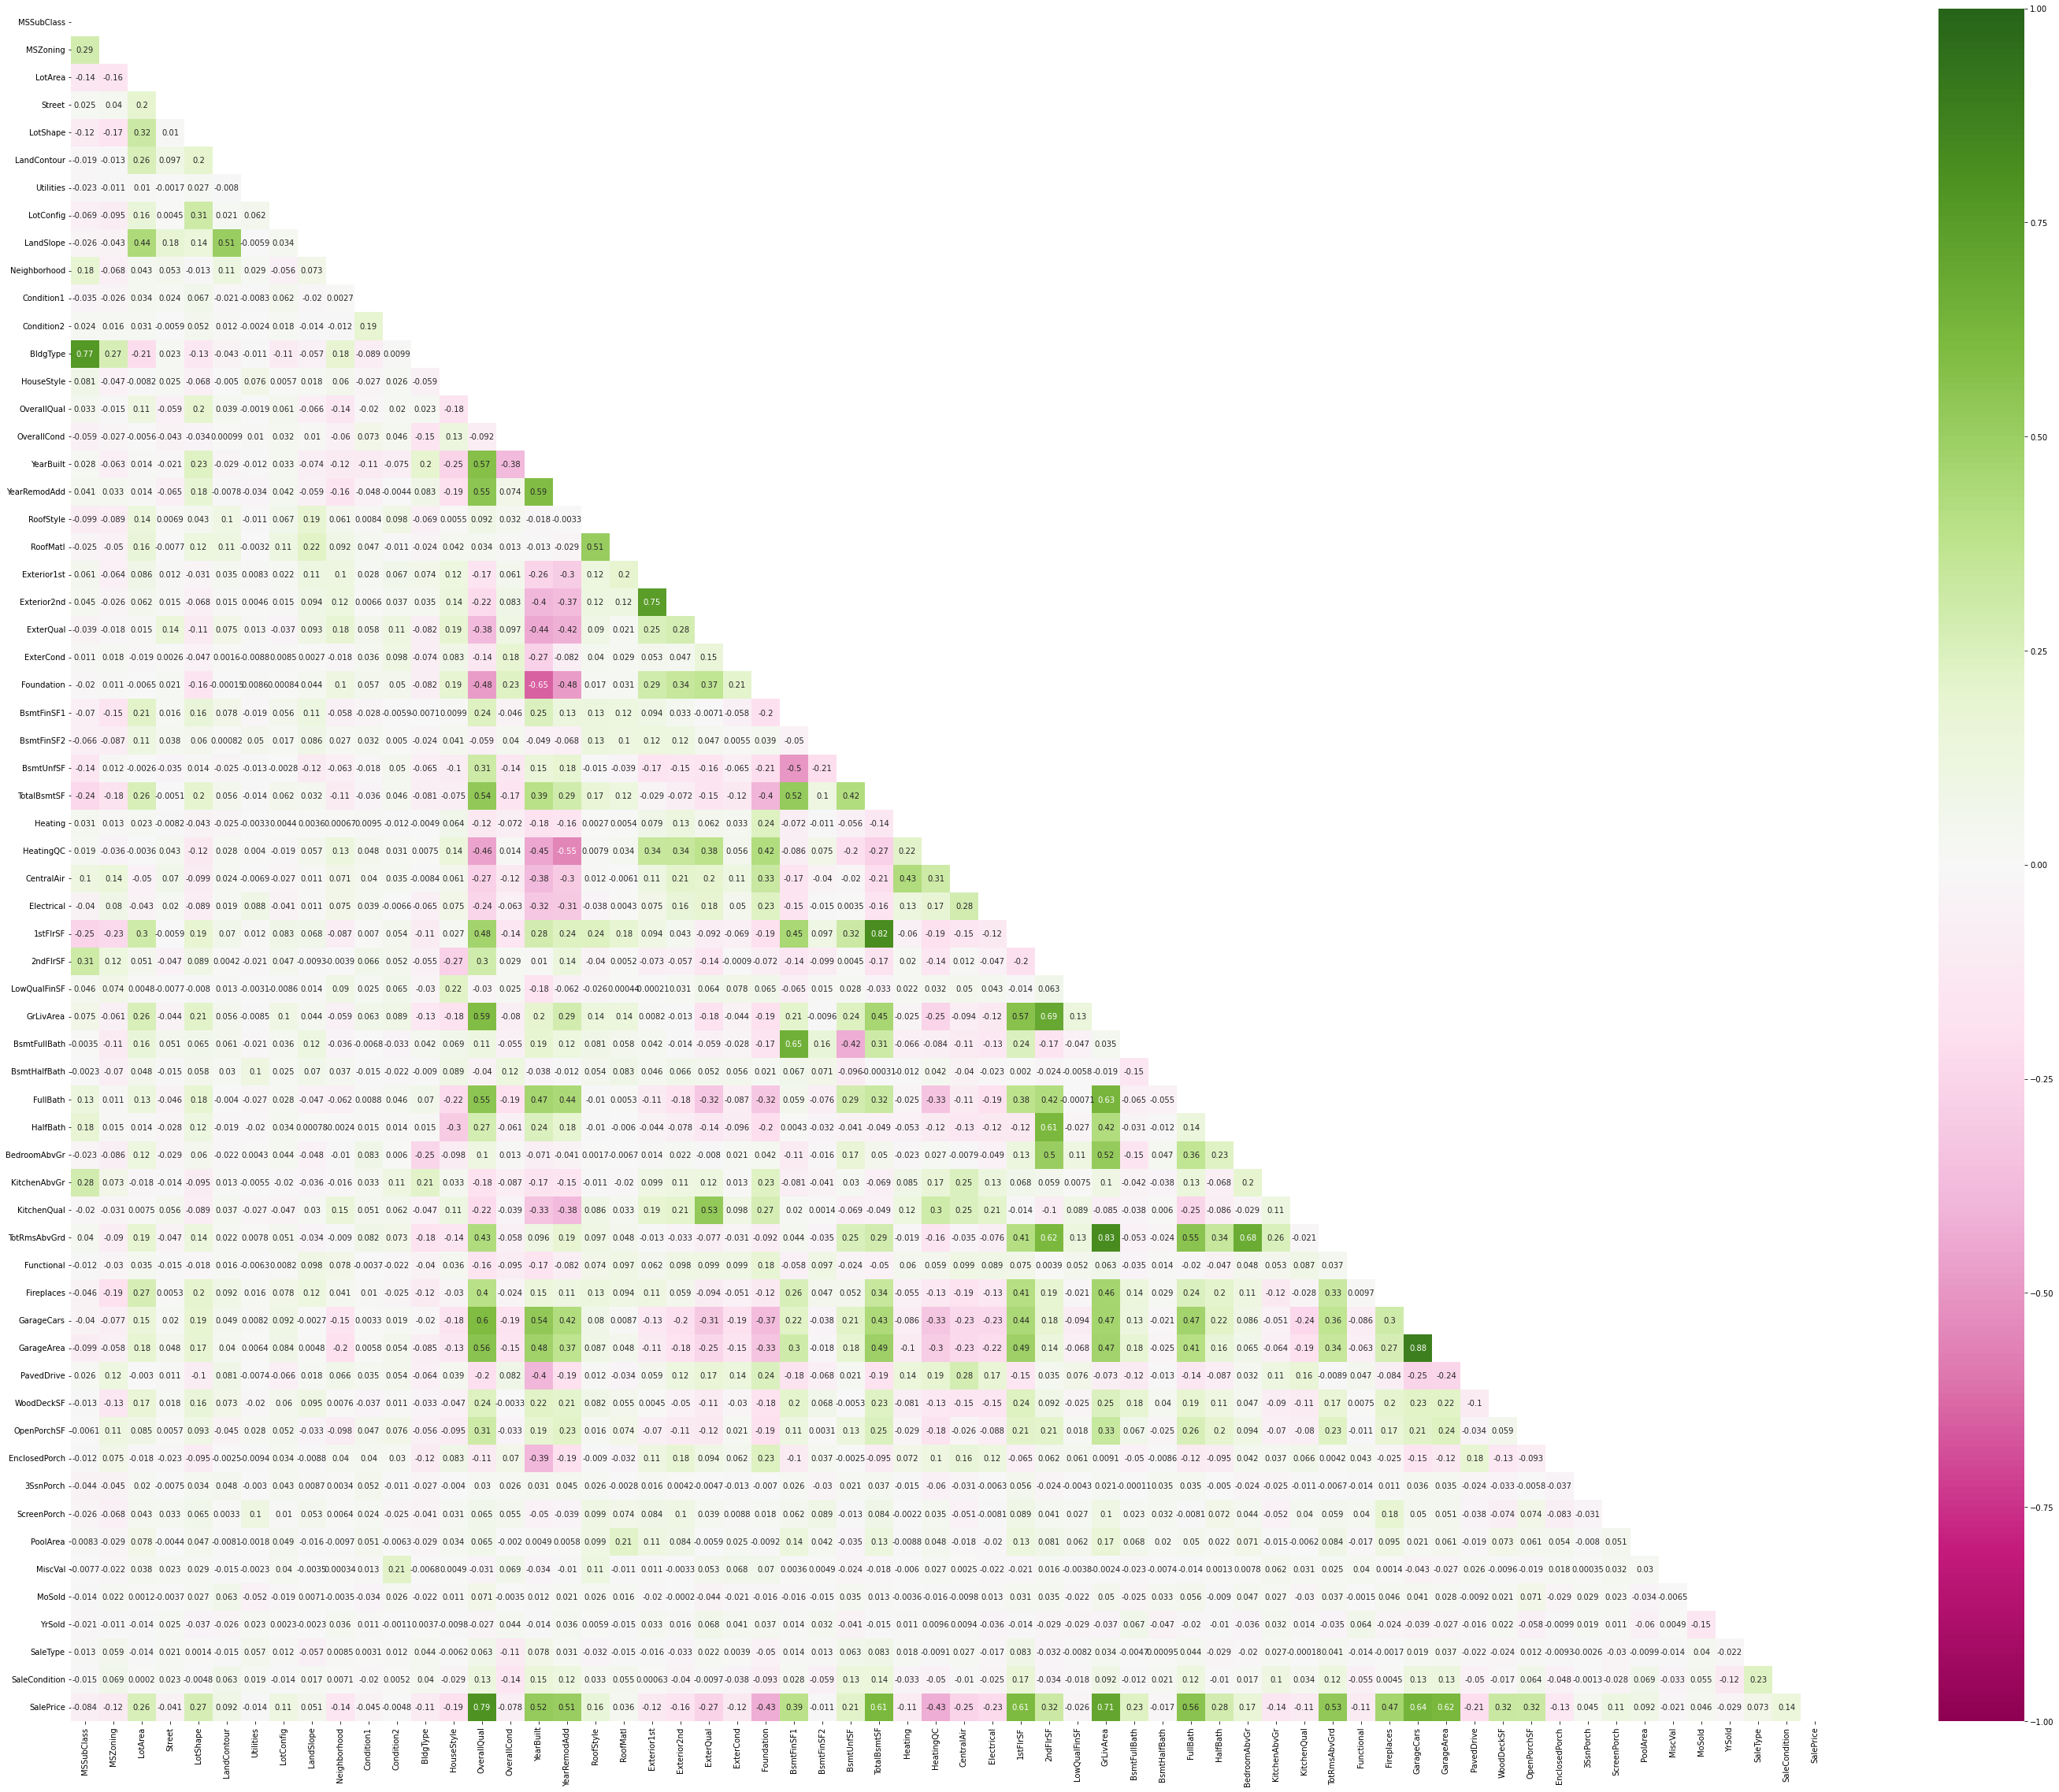

In [17]:
corr_threshold = 0.2
corr = train_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca())
high_corr = []
for column in train_data:
   for col in train_data:
     if abs(lower_tri[column][col]) > corr_threshold:
       high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))

In [ ]:
high_corr

[('GarageCars', 'GarageArea', 0.8824754142814631),
 ('GrLivArea', 'TotRmsAbvGrd', 0.8254893743088413),
 ('TotalBsmtSF', '1stFlrSF', 0.8195299750050328),
 ('OverallQual', 'SalePrice', 0.790981600583805),
 ('MSSubClass', 'BldgType', 0.7708396619425057),
 ('Exterior1st', 'Exterior2nd', 0.7495994661874026),
 ('GrLivArea', 'SalePrice', 0.7086244776126515),
 ('2ndFlrSF', 'GrLivArea', 0.6875010641666031),
 ('BedroomAbvGr', 'TotRmsAbvGrd', 0.6766199357426483),
 ('BsmtFinSF1', 'BsmtFullBath', 0.6492117535742656),
 ('GarageCars', 'SalePrice', 0.6404091972583519),
 ('GrLivArea', 'FullBath', 0.6300116462511156),
 ('GarageArea', 'SalePrice', 0.6234314389183616),
 ('2ndFlrSF', 'TotRmsAbvGrd', 0.616422635491543),
 ('TotalBsmtSF', 'SalePrice', 0.6135805515591953),
 ('2ndFlrSF', 'HalfBath', 0.6097073002717446),
 ('1stFlrSF', 'SalePrice', 0.6058521846919128),
 ('OverallQual', 'GarageCars', 0.6006707165907149),
 ('OverallQual', 'GrLivArea', 0.5930074300286505),
 ('YearBuilt', 'YearRemodAdd', 0.5928549763

##### Porzucenie kolumn z wysokim wskaźnikiem korelacji

In [18]:
# drop columns with high correlation
train_data = train_data.drop([x[0] for x in high_corr if x[0] in train_data], axis=1)
test_data_X = test_data_X.drop([x[0] for x in high_corr if x[0] in test_data_X], axis=1)

In [19]:
train_data_X = train_data.drop(['SalePrice'], axis=1)
train_data_Y = train_data.loc[:,["SalePrice"]].to_numpy()
test_data_Y = test_data_Y.to_numpy()

-----
-----

# Predykcja za pomocą różnych metod:


*   regresja liniowa
*   regrsja z regularyzacją z metodą Lasso
*   regresja za pomocą Random Forest w XGBoost



## Regresja Liniowa

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_model = LinearRegression()
linear_model.fit(train_data_X,train_data_Y, )  
predicted = linear_model.predict(test_data_X)

In [21]:
def results_sum_up(actual_prices, predicted_prices, show_n_elements=15):
    relative_error_list = []
    for i, (actual, predicted) in enumerate(zip(actual_prices, predicted_prices)):
        try:
            #sometimes values are stored in 1D arrays so we need to access them
            actual = actual[0]
            predicted = predicted[0]
        except:
            pass
        relative_error = np.abs((actual - predicted)/actual)
        relative_error_list.append(relative_error)
        if i < show_n_elements:
            print(f"Actual: {actual:.2f}\tPrediction: {predicted:.2f}\t\tDifference: {(100*relative_error):.2f}%")

    return np.sqrt(mean_squared_error(actual_prices, predicted_prices)), relative_error_list

##### Wyniki regresji liniowej

In [22]:
rmse, relative_errors = results_sum_up(test_data_Y, predicted)
print(f"\nRMSE = {rmse:.2f}\t mean(relative_erors) = {np.mean(relative_errors)*100:.2f}%")

Actual: 169277.05	Prediction: 207770.13		Difference: 22.74%
Actual: 187758.39	Prediction: 160304.30		Difference: 14.62%
Actual: 183583.68	Prediction: 183591.46		Difference: 0.00%
Actual: 179317.48	Prediction: 186621.38		Difference: 4.07%
Actual: 150730.08	Prediction: 199217.12		Difference: 32.17%
Actual: 177150.99	Prediction: 193155.74		Difference: 9.03%
Actual: 172070.66	Prediction: 182129.91		Difference: 5.85%
Actual: 175110.96	Prediction: 185611.41		Difference: 6.00%
Actual: 162011.70	Prediction: 182581.48		Difference: 12.70%
Actual: 160726.25	Prediction: 194823.04		Difference: 21.21%
Actual: 157933.28	Prediction: 205397.29		Difference: 30.05%
Actual: 145291.25	Prediction: 179246.88		Difference: 23.37%
Actual: 159672.02	Prediction: 180256.86		Difference: 12.89%
Actual: 164167.52	Prediction: 198728.08		Difference: 21.05%
Actual: 150891.64	Prediction: 198728.08		Difference: 31.70%

RMSE = 26813.97	 mean(relative_erors) = 11.19%


-----

## Regresja z regularyzacją Lasso

In [23]:
from sklearn.linear_model import Lasso

regular_lasso_model = Lasso(alpha=0.005, max_iter=50000)
regular_lasso_model.fit(train_data_X, train_data_Y)
predicted = regular_lasso_model.predict(test_data_X)

##### Wyniki regresji z regularyzacją Lasso

In [24]:
rmse, relative_errors = results_sum_up(test_data_Y, predicted)
print(f"\nRMSE = {rmse:.2f}\t mean(relative_erors) = {np.mean(relative_errors)*100:.2f}%")

Actual: 169277.05	Prediction: 207769.95		Difference: 22.74%
Actual: 187758.39	Prediction: 160307.90		Difference: 14.62%
Actual: 183583.68	Prediction: 183591.45		Difference: 0.00%
Actual: 179317.48	Prediction: 186621.36		Difference: 4.07%
Actual: 150730.08	Prediction: 199216.96		Difference: 32.17%
Actual: 177150.99	Prediction: 193155.69		Difference: 9.03%
Actual: 172070.66	Prediction: 182130.05		Difference: 5.85%
Actual: 175110.96	Prediction: 185611.39		Difference: 6.00%
Actual: 162011.70	Prediction: 182581.48		Difference: 12.70%
Actual: 160726.25	Prediction: 194822.99		Difference: 21.21%
Actual: 157933.28	Prediction: 205397.20		Difference: 30.05%
Actual: 145291.25	Prediction: 179246.88		Difference: 23.37%
Actual: 159672.02	Prediction: 180256.85		Difference: 12.89%
Actual: 164167.52	Prediction: 198728.00		Difference: 21.05%
Actual: 150891.64	Prediction: 198728.00		Difference: 31.70%

RMSE = 26813.81	 mean(relative_erors) = 11.19%


-----

## Random Forest Regression

In [26]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
                 colsample_bytree=0.05,
                 gamma=0.0,
                 learning_rate=0.0005,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42)
xgb_model.fit(train_data_X, train_data_Y)
predicted = xgb_model.predict(test_data_X)

##### Wyniki regresji z wykorzystaniem Random Forest w XGBoost

In [27]:
rmse, relative_errors = results_sum_up(test_data_Y, predicted)
print(f"\nRMSE = {rmse:.2f}\t mean(relative_erors) = {np.mean(relative_errors)*100:.2f}%")

Actual: 169277.05	Prediction: 176235.89		Difference: 4.11%
Actual: 187758.39	Prediction: 168990.23		Difference: 10.00%
Actual: 183583.68	Prediction: 176770.20		Difference: 3.71%
Actual: 179317.48	Prediction: 175962.09		Difference: 1.87%
Actual: 150730.08	Prediction: 174386.30		Difference: 15.69%
Actual: 177150.99	Prediction: 174523.61		Difference: 1.48%
Actual: 172070.66	Prediction: 169372.39		Difference: 1.57%
Actual: 175110.96	Prediction: 175486.88		Difference: 0.21%
Actual: 162011.70	Prediction: 176038.78		Difference: 8.66%
Actual: 160726.25	Prediction: 170445.41		Difference: 6.05%
Actual: 157933.28	Prediction: 172913.00		Difference: 9.48%
Actual: 145291.25	Prediction: 196241.61		Difference: 35.07%
Actual: 159672.02	Prediction: 196973.00		Difference: 23.36%
Actual: 164167.52	Prediction: 165297.58		Difference: 0.69%
Actual: 150891.64	Prediction: 165297.58		Difference: 9.55%

RMSE = 21550.42	 mean(relative_erors) = 9.02%


### Grid search po parametrach w celu wybrania najbardziej optymalnego zestawu

In [28]:
def mean_relative_error(actual_prices, predicted_prices):
    relative_error_list = []
    for i, (actual, predicted) in enumerate(zip(actual_prices, predicted_prices)):
        try:
            actual = actual[0]
            predicted = predicted[0]
        except:
            pass
        relative_error = np.abs((actual - predicted)/actual)
        relative_error_list.append(relative_error)

    return - np.mean(relative_error_list)*100

custom_scorer = make_scorer(mean_relative_error, greater_is_better=False)

In [ ]:
# model = xgb.XGBRegressor(objective='reg:squarederror')
# parameters = {'nthread' : [4],              
#               'colsample_bytree' : list(np.arange(0.02, 0.1, 0.02)),
#               'gamma' : [0.0],
#               'learning_rate' : list(np.arange(0.0003, 0.0008, 0.0001)),
#               'max_depth' : list(np.arange(4, 9, 1)),
#               'min_child_weight' : [1.5],
#               'n_estimators' : list(np.arange(5000, 8000, 800)),
#               'reg_alpha' : [0.9],
#               'reg_lambda' : [0.6],
#               'subsample' : [0.2],
#               'seed' : [42] }


# model_xgb_grid = GridSearchCV(estimator=model,
#                         param_grid=parameters,
#                         # cv=2,
#                         n_jobs=8,
#                         scoring=custom_scorer,
#                         verbose=10
#                         )

# model_xgb_grid.fit(train_data_X, train_data_Y)

# print(model_xgb_grid.best_score_)
# print(model_xgb_grid.best_params_)

##### Wyniki Grid Search'a

Best parameters:

* przypadek bez usuniętych kolumn zawierających dużą ilość wartości NaN

{'colsample_bytree': 0.02, 'gamma': 0.0, 'learning_rate': 0.0005, 'max_depth': 4, 'min_child_weight': 1.5, 'n_estimators': 7400, 'nthread': 4, 'reg_alpha': 0.9, 'reg_lambda': 0.6, 'seed': 42, 'subsample': 0.2}

------

* z usuniętymi kolumnami z dużą ilością wartości NaN

{'colsample_bytree': 0.02, 'gamma': 0.0, 'learning_rate': 0.0006999999999999999, 'max_depth': 4, 'min_child_weight': 1.5, 'n_estimators': 5800, 'nthread': 4, 'reg_alpha': 0.9, 'reg_lambda': 0.6, 'seed': 42, 'subsample': 0.2}

##### Wytrenowanie modelu na znalezionym najlepszym zestawie parametrów

In [29]:
model = xgb.XGBRegressor(colsample_bytree=0.02,
                         gamma=0.0, 
                         learning_rate=0.0006999999999999999,
                         max_depth=4,
                         min_child_weight=1.5,
                         n_estimators=5800,
                         nthread=4,
                         reg_alpha=0.9,
                         reg_lambda=0.6,
                         seed=42,
                         subsample=0.2)

# model = xgb.XGBRegressor(
#     **model_xgb_grid.best_params_
# )
model.fit(train_data_X, train_data_Y)
predicted = model.predict(test_data_X)
rmse, relative_errors = results_sum_up(test_data_Y, predicted)
print("\nRMSE = {:.2f}\t mean(relative_erors) = {:.2f}%".format(rmse, np.mean(relative_errors)*100))

Actual: 169277.05	Prediction: 178511.58		Difference: 5.46%
Actual: 187758.39	Prediction: 170214.03		Difference: 9.34%
Actual: 183583.68	Prediction: 178287.91		Difference: 2.88%
Actual: 179317.48	Prediction: 177512.84		Difference: 1.01%
Actual: 150730.08	Prediction: 175967.72		Difference: 16.74%
Actual: 177150.99	Prediction: 175920.09		Difference: 0.69%
Actual: 172070.66	Prediction: 169830.66		Difference: 1.30%
Actual: 175110.96	Prediction: 176916.78		Difference: 1.03%
Actual: 162011.70	Prediction: 177752.67		Difference: 9.72%
Actual: 160726.25	Prediction: 171917.02		Difference: 6.96%
Actual: 157933.28	Prediction: 174700.33		Difference: 10.62%
Actual: 145291.25	Prediction: 198881.47		Difference: 36.88%
Actual: 159672.02	Prediction: 199416.69		Difference: 24.89%
Actual: 164167.52	Prediction: 168377.83		Difference: 2.56%
Actual: 150891.64	Prediction: 168377.83		Difference: 11.59%

RMSE = 21119.87	 mean(relative_erors) = 8.75%


-----

## Analiza SHAP

#### Regresja liniowa

Estimating transforms: 100%|██████████| 1000/1000 [00:00<00:00, 1772.48it/s]


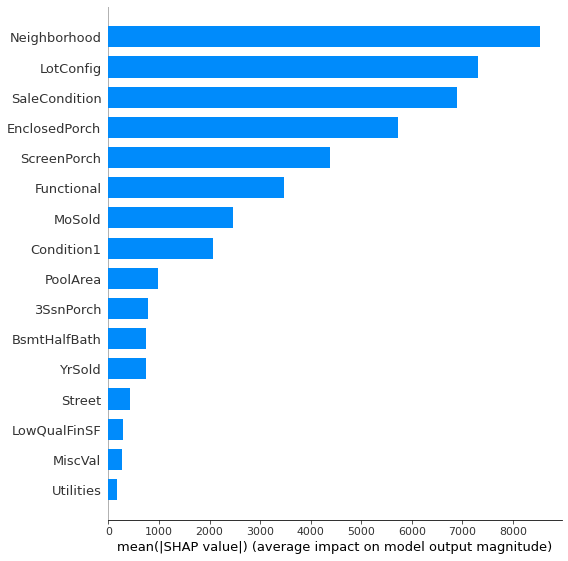

In [30]:
masker = shap.maskers.Impute(data=train_data_X)
shap_values = shap.explainers.Linear(linear_model, masker=masker).shap_values(train_data_X)
# shap_values = shap.TreeExplainer(linear_model).shap_values(train_data_X)
shap.summary_plot(shap_values, train_data_X, plot_type="bar")

#### Regresja z regularyzacją Lasso

Estimating transforms: 100%|██████████| 1000/1000 [00:00<00:00, 1678.39it/s]


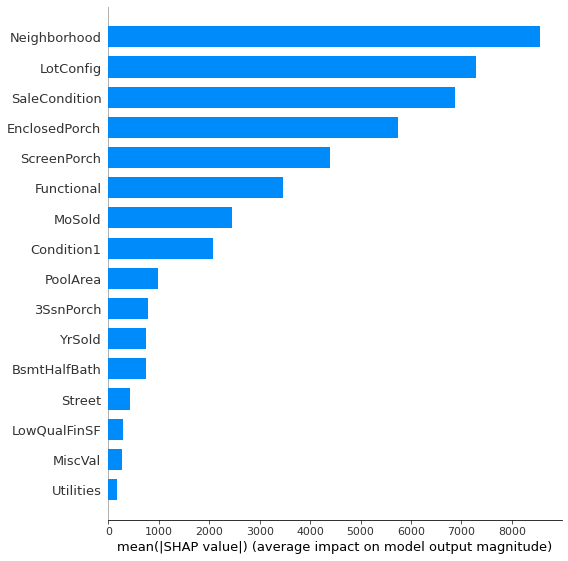

In [31]:
masker = shap.maskers.Impute(data=train_data_X)
shap_values = shap.explainers.Linear(regular_lasso_model, masker=masker).shap_values(train_data_X)
shap.summary_plot(shap_values, train_data_X, plot_type="bar")

#### Random Forest Regression

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


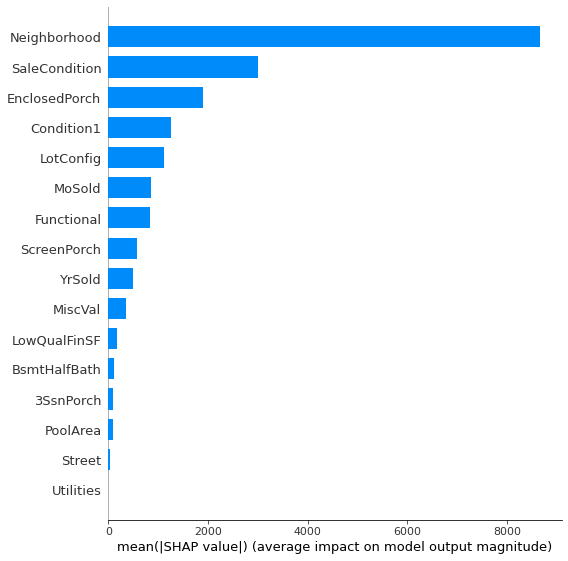

In [32]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(train_data_X)
shap.summary_plot(shap_values, train_data_X, plot_type="bar")

In [33]:
for x in train_data_X:
    print(x)

Street
Utilities
LotConfig
Neighborhood
Condition1
LowQualFinSF
BsmtHalfBath
Functional
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
SaleCondition
